In [52]:
!pip install optuna
!pip install graphviz
!pip install shap

In [53]:
#Imports needed libraries
import numpy as np #linear algebra
import pandas as pd #data manipulation
import matplotlib.pyplot as plt #data viz
from matplotlib.gridspec import GridSpec #data viz
from matplotlib.animation import FuncAnimation #animation
import seaborn as sns #data viz
#data preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline

from sklearn.decomposition import PCA #principle component analysis
from IPython.display import HTML #display gif
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

from imblearn.over_sampling import SMOTE #balance classes
import optuna
#models to try out
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

import graphviz #graph of model
#metrics
from sklearn import metrics
#shap
import shap
import warnings #warnings
warnings.filterwarnings('ignore') #Hides warning popups

In [54]:
data = pd.read_csv(f'/content/drive/MyDrive/Lab/Dataset/Dataset of Diabetes  (1).csv')


In [55]:
data.head()

,ID,No_Pation,Gender,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI,CLASS
0,502,17975,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
1,735,34221,M,26,4.5,62,4.9,3.7,1.4,1.1,2.1,0.6,23.0,N
2,420,47975,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
3,680,87656,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
4,504,34223,M,33,7.1,46,4.9,4.9,1.0,0.8,2.0,0.4,21.0,N


In [56]:
data = data.drop(['ID','No_Pation'], axis=1)

In [57]:
data.rename(columns={
    'Urea': 'Blood Urea Nitrogen',
    'Cr': 'Creatinine',
    'HbA1c': 'Hemoglobin A1c',
    'Chol': 'Total Cholesterol',
    'TG': 'Triglycerides',
    'HDL': 'HDL Cholesterol',
    'LDL': 'LDL Cholesterol',
    'VLDL': 'Very Low-Density Lipoprotein',
    'CLASS': 'Diabetes'
}, inplace=True)

In [58]:
data['Diabetes'].value_counts()

,count
Diabetes,
Y,840
N,102
P,53
Y,4
N,1


In [59]:
data['Diabetes']=data['Diabetes'].map({"Y":1, 'N':0, "P":1})
data['Gender'] = data['Gender'].map({'M': 0, 'F': 1, 'f':1})


In [60]:
data = data.dropna(axis=0)
data.isnull().sum()

,0
Gender,0
AGE,0
Blood Urea Nitrogen,0
Creatinine,0
Hemoglobin A1c,0
Total Cholesterol,0
Triglycerides,0
HDL Cholesterol,0
LDL Cholesterol,0
Very Low-Density Lipoprotein,0


In [61]:
x = data.drop('Diabetes', axis=1)
y = data['Diabetes']
data = data.astype(float)


# Split data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=8)

# Apply SMOTE to balance the training data
sm = SMOTE(random_state=8)
smoted_x_train, smoted_y_train = sm.fit_resample(x_train, y_train)

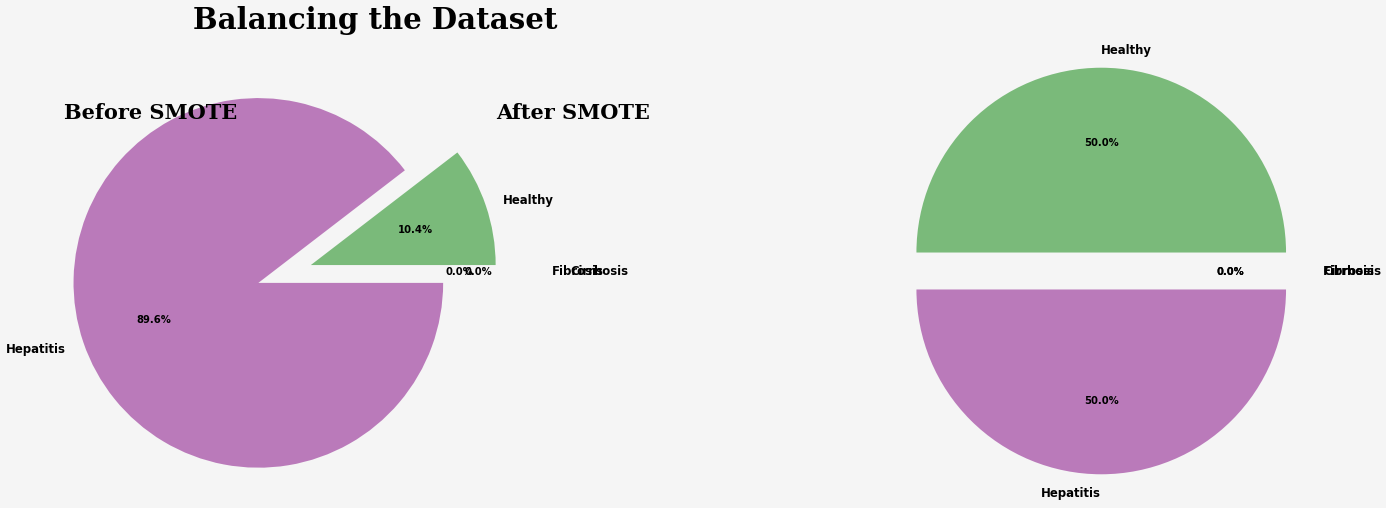

In [62]:


# Plot target data
fig = plt.figure(figsize=(24, 10), dpi=60)
gs = GridSpec(ncols=13, nrows=5, left=0.05, right=0.95, wspace=0.2, hspace=0.1)
fig.patch.set_facecolor('#f5f5f5')
sns.set_palette(sns.color_palette(['green', 'purple', 'orange', 'red']))

ax1 = fig.add_subplot(gs[:, 0:5])
ax2 = fig.add_subplot(gs[:, 8:])

# Axes list
axes = [ax1, ax2]

# Setting of axes; visibility of axes and spines turn off
for ax in axes:
    ax.axes.get_yaxis().set_visible(False)
    ax.set_facecolor('#f5f5f5')

    for loc in ['left', 'right', 'top', 'bottom']:
        ax.spines[loc].set_visible(False)

#------------------------------------------------------------
# ax1 (Before SMOTE)
pre_smote_count = [len(y_train[y_train == 0.0]), len(y_train[y_train == 1.0]),
                   len(y_train[y_train == 2.0]), len(y_train[y_train == 3.0])]
ax1_plot = ax1.pie(pre_smote_count,
                   labels=['Healthy', 'Hepatitis', 'Fibrosis', 'Cirrhosis'],
                   autopct='%1.1f%%', explode=[0.1, 0.2, 0.3, 0.4],
                   colors=['green', 'purple', 'orange', 'red'])

for piece in ax1_plot[0]:
    piece.set_alpha(0.5)

for text in ax1_plot[1]:
    text.set_weight('bold')
    text.set_size(14)

for text in ax1_plot[2]:
    text.set_weight('bold')
    text.set_size(12)

fig.text(0.06, 0.75, 'Before SMOTE', {'font': 'Serif', 'weight': 'bold', 'color': 'black', 'size': 25})
#------------------------------------------------------------
# ax2 (After SMOTE)
post_smote_count = [len(smoted_y_train[smoted_y_train == 0.0]), len(smoted_y_train[smoted_y_train == 1.0]),
                    len(smoted_y_train[smoted_y_train == 2.0]), len(smoted_y_train[smoted_y_train == 3.0])]
ax2_plot = ax2.pie(post_smote_count,
                   labels=['Healthy', 'Hepatitis', 'Fibrosis', 'Cirrhosis'],
                   autopct='%1.1f%%', explode=[0.1, 0.1, 0.1, 0.1],
                   colors=['green', 'purple', 'orange', 'red'])

for piece in ax2_plot[0]:
    piece.set_alpha(0.5)

for text in ax2_plot[1]:
    text.set_weight('bold')
    text.set_size(14)

for text in ax2_plot[2]:
    text.set_weight('bold')
    text.set_size(12)

fig.text(0.36, 0.75, 'After SMOTE', {'font': 'Serif', 'weight': 'bold', 'color': 'black', 'size': 25})
#--------------------------------
fig.text(0.15, 0.9, 'Balancing the Dataset',
         {'font': 'Serif', 'weight': 'bold', 'color': 'black', 'size': 35})

plt.show()


In [63]:
# OPTUNA objective function
def objective(trial):
    #------------------------------
    #logistic regression
    lr_penalty = trial.suggest_categorical('lr_penalty', ['l1', 'l2', 'elasticnet'])
    lr_l1_ratio = None
    if lr_penalty == 'l1':
        lr_solver = trial.suggest_categorical('lr_solver1', ['liblinear', 'saga'])
    elif lr_penalty == 'l2':
        lr_solver = trial.suggest_categorical('lr_solver2', ['newton-cg', 'lbfgs', 'sag', 'liblinear', 'saga'])
    else:
        lr_solver = 'saga'
        lr_l1_ratio = trial.suggest_uniform('lr_l1_ratio', 0.0, 1.0)

    lr_tol = trial.suggest_uniform('lr_tol', 1e-5, 1e-2)
    lr_C = trial.suggest_uniform('lr_C', 0.0, 1.0)

    lr = LogisticRegression(
        penalty=lr_penalty,
        tol=lr_tol,
        C=lr_C,
        solver=lr_solver,
        l1_ratio=lr_l1_ratio
    )


    #----------------------------------------------------------
    #KNN
    knn_neighbors = trial.suggest_int('knn_neighbors', 2, 100)
    knn_weights = trial.suggest_categorical('knn_weights', ['uniform', 'distance'])
    knn_p = trial.suggest_categorical('knn_p', [1, 2])

    knn = KNeighborsClassifier(
        n_neighbors=knn_neighbors,
        weights=knn_weights,
        p=knn_p
    )


    #----------------------------------------------------------
    #SVM
    svm_C = trial.suggest_uniform('svm_C', 0.0, 1.0)
    svm_kernel = trial.suggest_categorical('svm_kernel', ['poly', 'rbf'])
    svm_degree = 3
    if svm_kernel == 'poly':
        svm_degree = trial.suggest_int('svm_degree', 1, 10)
    svm_tol = trial.suggest_uniform('svm_tol', 1e-5, 1e-2)

    svm = SVC(
        C=svm_C,
        kernel=svm_kernel,
        degree=svm_degree,
        tol=svm_tol
    )

    #-----------------------------------------------------------
    #random forest
    rf_estimators = trial.suggest_int('rf_estimators', 1, 500)
    rf_criterion = trial.suggest_categorical('rf_criterion', ['entropy', 'gini'])
    rf_max_depth = trial.suggest_int('rf_max_depth', 1, 100)
    rf_min_samples_split = trial.suggest_int('rf_min_samples_split', 2, 50)
    rf_min_samples_leaf = trial.suggest_int('rf_min_samples_leaf', 1, 25)

    rf = RandomForestClassifier(
        n_estimators=rf_estimators,
        criterion=rf_criterion,
        max_depth=rf_max_depth,
        min_samples_split=rf_min_samples_split,
        min_samples_leaf=rf_min_samples_leaf
    )


    #---------------------------------------------------------
    #naive bayes
    nb_smoothing = trial.suggest_uniform('nb_smoothing', 1e-10, 1e-6)
    nb = GaussianNB(var_smoothing=nb_smoothing)


    #---------------------------------------------------------

    #ensemble model
    lr_w = trial.suggest_uniform('lr_w', 0.0, 1.0)
    knn_w = trial.suggest_uniform('knn_w', 0.0, 1.0)
    svm_w = trial.suggest_uniform('svm_w', 0.0, 1.0)
    rf_w = trial.suggest_uniform('rf_w', 0.0, 1.0)
    nb_w = trial.suggest_uniform('nb_w', 0.0, 1.0)


    vc = VotingClassifier(estimators=[
        ('lr', lr),
        ('knn', knn),
        ('svm', svm),
        ('rf', rf),
        ('nb', nb)],
                          weights=[lr_w, knn_w, svm_w, rf_w, nb_w]
                         )

    vc.fit(smoted_x_train, smoted_y_train)
    preds = vc.predict(x_test)

    acc = metrics.accuracy_score(y_test, preds)

    return acc

In [64]:
optuna.logging.set_verbosity(optuna.logging.ERROR)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

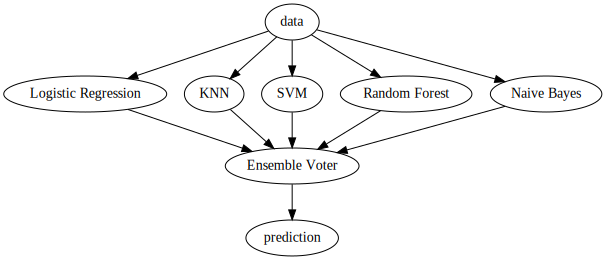

In [65]:
ensemble_graph = graphviz.Digraph()
#first layer
ensemble_graph.edge('data', 'Logistic Regression')
ensemble_graph.edge('data', 'KNN')
ensemble_graph.edge('data', 'SVM')
ensemble_graph.edge('data', 'Random Forest')
ensemble_graph.edge('data', 'Naive Bayes')
#second layer
ensemble_graph.edge('Logistic Regression', 'Ensemble Voter')
ensemble_graph.edge('KNN', 'Ensemble Voter')
ensemble_graph.edge('SVM', 'Ensemble Voter')
ensemble_graph.edge('Random Forest', 'Ensemble Voter')
ensemble_graph.edge('Naive Bayes', 'Ensemble Voter')
#third layer
ensemble_graph.edge('Ensemble Voter', 'prediction')

ensemble_graph

In [66]:
print('===========================================================')
print('Model Accuracy on Valadation Set:', round(study.best_trial.values[0], 2))
print('===========================================================')
print('Best Hyperparameters:')
print('===========================================================')
print(study.best_params)

Model Accuracy on Valadation Set: 0.99
Best Hyperparameters:
{'lr_penalty': 'l1', 'lr_solver1': 'saga', 'lr_tol': 0.004232921128813114, 'lr_C': 0.2959145922881675, 'knn_neighbors': 38, 'knn_weights': 'distance', 'knn_p': 2, 'svm_C': 0.9490850965194584, 'svm_kernel': 'poly', 'svm_degree': 4, 'svm_tol': 0.0010777082457878828, 'rf_estimators': 207, 'rf_criterion': 'entropy', 'rf_max_depth': 83, 'rf_min_samples_split': 3, 'rf_min_samples_leaf': 3, 'nb_smoothing': 3.388198952650939e-07, 'lr_w': 0.47956583002029224, 'knn_w': 0.002893071032184613, 'svm_w': 0.32256296970100756, 'rf_w': 0.9557702466804276, 'nb_w': 0.11665257962586463}


In [67]:
def create_model(best_params):
    try:
        l1_ratio = best_params['lr_l1_ratio']
    except KeyError:
        l1_ratio = None
    try:
        solver = best_params['lr_solver1']
    except KeyError:
        try:
            solver = best_params['lr_solver2']
        except KeyError:
            solver = 'saga'

    lr = LogisticRegression(
        penalty=best_params['lr_penalty'],
        tol=best_params['lr_tol'],
        C=best_params['lr_C'],
        l1_ratio=l1_ratio,
        solver=solver
    )

    knn = KNeighborsClassifier(
        n_neighbors=best_params['knn_neighbors'],
        weights=best_params['knn_weights'],
        p=best_params['knn_p']
    )

    try:
        svm_degree = best_params['svm_degree']
    except KeyError:
        svm_degree = 3

    svm = SVC(
        C=best_params['svm_C'],
        kernel=best_params['svm_kernel'],
        degree=svm_degree,
        tol=best_params['svm_tol']
    )

    rf = RandomForestClassifier(
        n_estimators=best_params['rf_estimators'],
        criterion=best_params['rf_criterion'],
        max_depth=best_params['rf_max_depth'],
        min_samples_split=best_params['rf_min_samples_split'],
        min_samples_leaf=best_params['rf_min_samples_leaf']
    )

    nb = GaussianNB(var_smoothing=best_params['nb_smoothing'])

    vc = VotingClassifier(
        estimators=[
            ('lr', lr),
            ('knn', knn),
            ('svm', svm),
            ('rf', rf),
            ('nb', nb)
        ],
        weights=[
            best_params['lr_w'],
            best_params['knn_w'],
            best_params['svm_w'],
            best_params['rf_w'],
            best_params['nb_w']
        ]
    )

    vc.fit(smoted_x_train, smoted_y_train)

    return vc

In [68]:
#ensemble model with best hyperparameters
model = create_model(study.best_params)

In [69]:
y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')  # Use 'macro', 'micro', or 'binary' depending on your problem
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Generate classification report
report = classification_report(y_test, y_pred, output_dict=True)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)


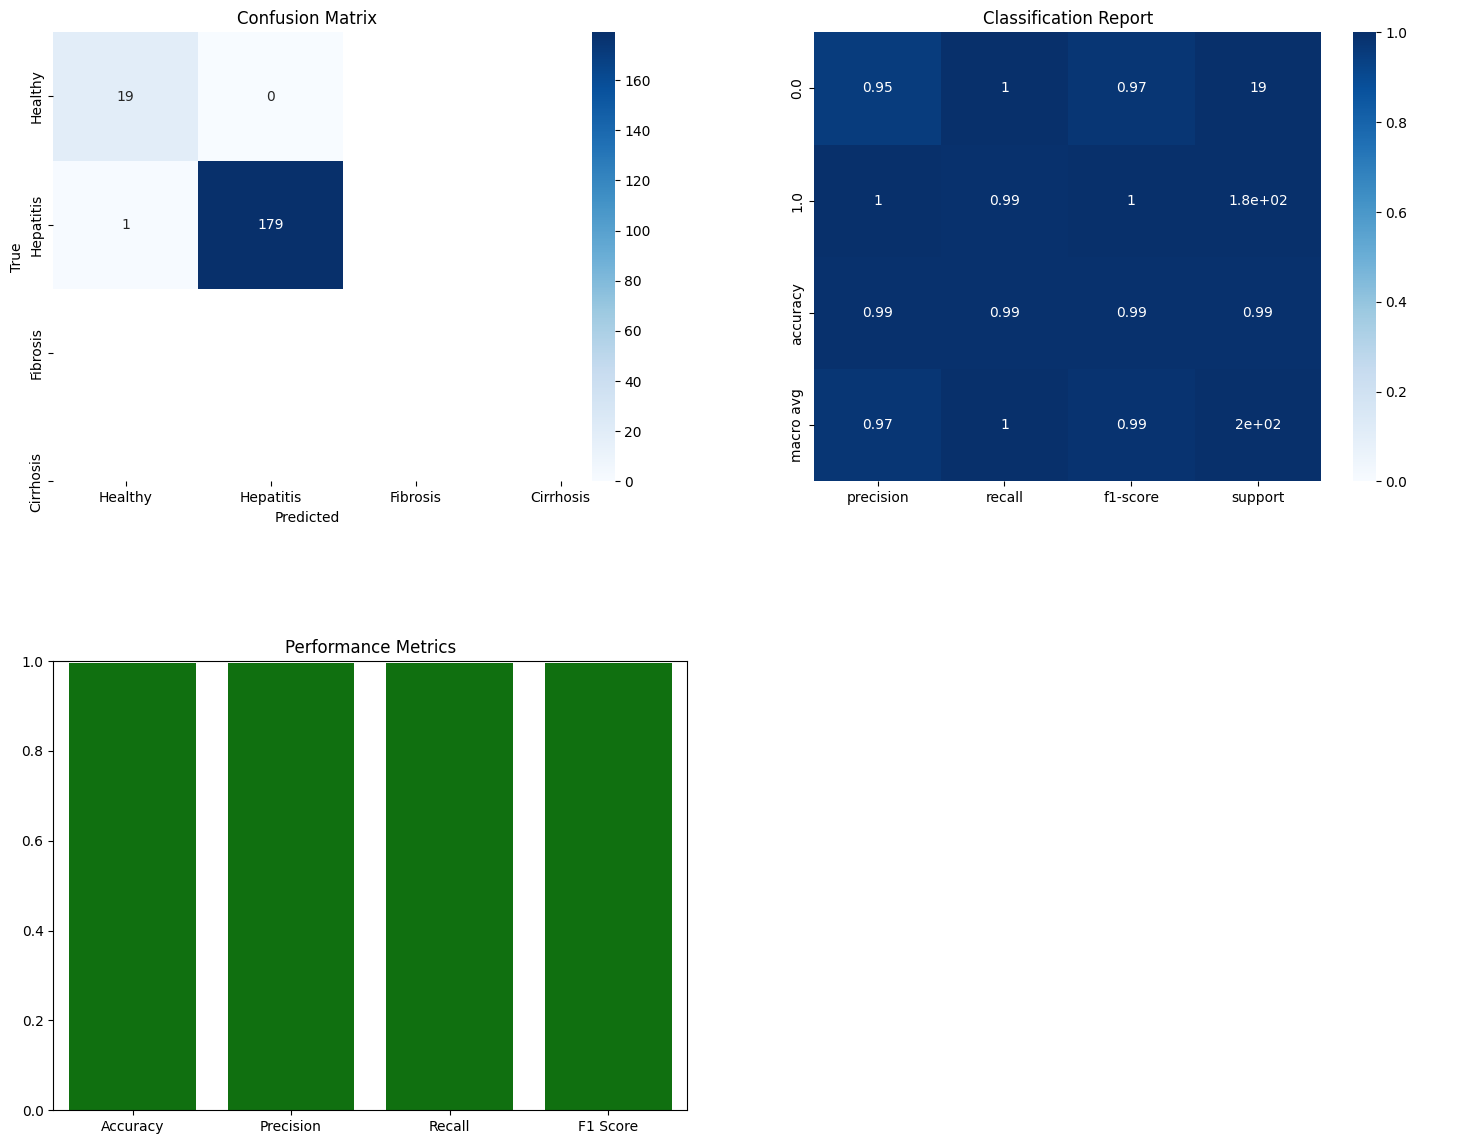

In [70]:

def plot_performance_metrics(accuracy, precision, recall, f1, report, cm, class_names):
    """
    Plot performance metrics of the given model.

    Parameters:
    - accuracy: Accuracy score of the model
    - precision: Precision score of the model
    - recall: Recall score of the model
    - f1: F1 score of the model
    - report: Classification report as a dictionary
    - cm: Confusion matrix
    - class_names: List of class names for confusion matrix labels
    """
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    plt.subplots_adjust(hspace=0.4)

    # Plot Confusion Matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=axes[0, 0])
    axes[0, 0].set_xlabel('Predicted')
    axes[0, 0].set_ylabel('True')
    axes[0, 0].set_title('Confusion Matrix')

    # Plot Classification Report
    df_report = pd.DataFrame(report).transpose()
    # Make sure to include class names and not numerical indices
    df_report.index = [class_names[int(idx)] if idx.isdigit() else idx for idx in df_report.index]
    sns.heatmap(df_report.iloc[:-1, :].astype(float), annot=True, cmap='Blues', vmin=0, vmax=1, ax=axes[0, 1])
    axes[0, 1].set_title('Classification Report')

    # Plot Performance Metrics
    metrics = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }
    sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), ax=axes[1, 0])
    axes[1, 0].set_ylim(0, 1)
    axes[1, 0].set_title('Performance Metrics')

    # Hide empty subplot
    axes[1, 1].axis('off')

    plt.show()

# Prepare class names
class_names = ['Healthy', 'Hepatitis', 'Fibrosis', 'Cirrhosis']

# Calculate metrics
y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Generate classification report and confusion matrix
report = classification_report(y_test, y_pred, output_dict=True)
cm = confusion_matrix(y_test, y_pred)

# Usage example
plot_performance_metrics(accuracy, precision, recall, f1, report, cm, class_names)


In [71]:
accuracy

0.9949748743718593

In [77]:
import joblib

joblib.dump(model, '/content/drive/MyDrive/Lab/Diabetis_prediction.pkl')

['/content/drive/MyDrive/Lab/Diabetis_prediction.pkl']

<a id="6"></a>
# 6. Model Evaluation on Test Set and Explination with SHAP

In [73]:
feature_names = list(data.columns)[1:2] + list(data.columns)[3:] + [list(data.columns)[2]]
explainer = shap.Explainer(model.predict, smoted_x_train, feature_names=feature_names)

# Compute SHAP values (use appropriate data for x_test)
shap_values = explainer(x_test)



PermutationExplainer explainer: 200it [14:08,  4.28s/it]


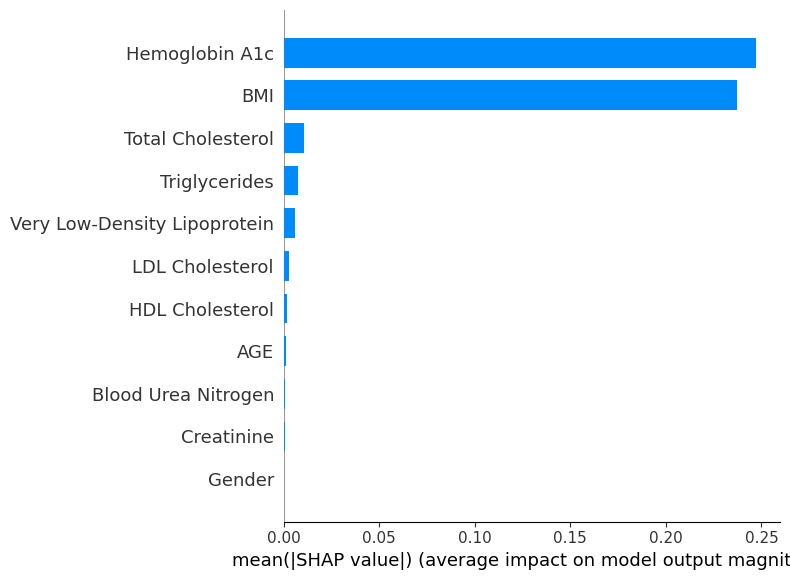

In [74]:
#plots importance of each feature
shap.summary_plot(shap_values, x_test, plot_type="bar")

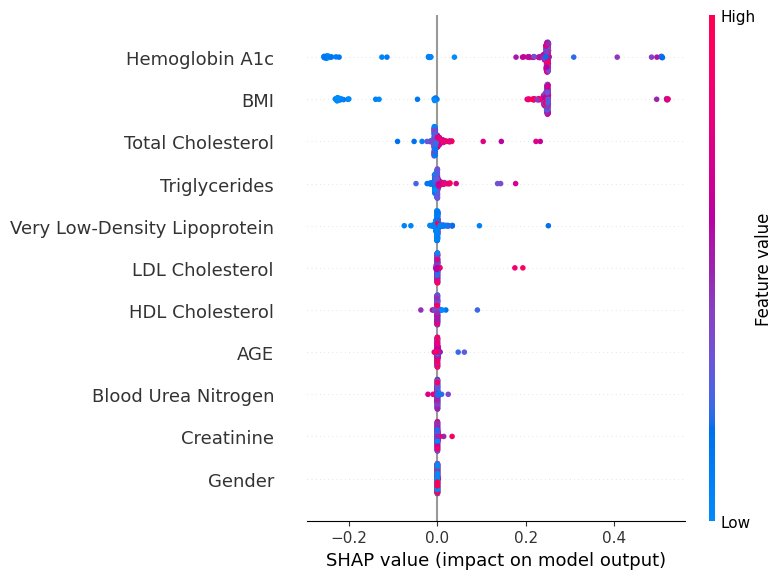

In [75]:
#plots importance of each feature
shap.summary_plot(shap_values, x_test)

In [76]:
#displays the final evaluation
test_preds = model.predict(x_test)
print('Test Accuracy:', round(metrics.accuracy_score(y_test, test_preds), 2))

Test Accuracy: 0.99
